# Clustering & Unsupervised Classification

*N. Hernitschek, 2022*

This is the twelfth Jupyter notebook for **ASTR 3890 - Selected Topics: Data Science for Large Astronomical Surveys (Spring 2022)**. 
This Jupyter notebook gives an introduction to the usage of scikit-learn.

It is based on code from the textbook

Statistics, Data Mining and Machine Learning in Astronomy: A Practical Python Guide for the Analysis of
Survey Data - Z. Ivezic, A. J. Connolly, J. T. VanderPlas, A. Gray

as well as on the scikit-learn online documentation.

***Exercises required for class participation are in <font color='red'>red</font>.***


---
## Contents
* [Clustering Algorithms](#first-bullet)
* [Unsupervised Classification: Anomaly Detection](#second-bullet)

## 1. Clustering Algorithms <a class="anchor" id="first-bullet"></a>


Clustering algorithms attempt to group together similar objects in a data set.

This process allows us to put new objects into the resulting classes and to identify rare objects that don't fit any class. **Clustering is inherently an "unsupervised" process** as we do not know the classification of the objects. Scikit-Learn's clustering suite is summarized at [http://scikit-learn.org/stable/modules/clustering.html](http://scikit-learn.org/stable/modules/clustering.html).

### $K$-Means Clustering <a class="anchor" id="twoa"></a>

We start with [$K$-means clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), which is one of the simplest methods.  $K$-means seeks to minimize the following

$$\sum_{k=1}^{K}\sum_{i\in C_k}||x_i - \mu_k||^2$$

where $\mu_k = \frac{1}{N_k}\sum_{i\in C_k} x_i$

In words, this says to
  * Take every object in class $C_k$ (as determined by which centroid it is closest to, specifically $C_k(x_i) = \arg \min_k ||x_i-\mu_k||)$
  * Compute the mean of the objects in that class
  * Subtract that mean from each member of that class and square the norm
  * Do that for each class and sum
  * Shift the centroids of the *pre-determined* number of classes until this sum is minimized
  * Do this multiple times with different starting centroids and take the result with the minimum sum
  
A typical call will look like in the following code example:


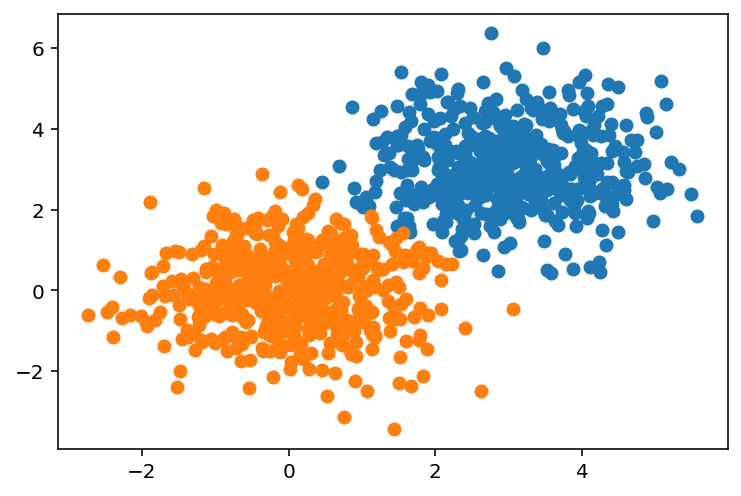

In [1]:
# Execute this cell
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from sklearn.cluster import KMeans
from sklearn import preprocessing

#X = np.random.normal(size=(1000,2)) #1000 points in 2D
X = np.concatenate([np.random.normal(size=(500,2)),
                   np.random.normal(loc=3.0, size=(500,2))]) # 1000  points in 2D
clf = KMeans(n_clusters=2) #Try 2 clusters to start with
clf.fit(X)
centers = clf.cluster_centers_ #alocation of the clusters
labels = clf.predict(X) #labels for each of the points

# plot the data color-coded by cluster id
colors = ['C0', 'C1', 'C2']
for ii in range(3):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], 
                color=colors[ii])

# To get some information on these try:
# KMeans?
# help(clf)

Here is an example of **K-means clustering on some multi-dimensional data**. The example and data derive from G. Richards' lecture "DE2andClustering.ipynb", where he attributes this to Professor Cruz.

In [2]:
# Execute the next few cells
from astropy.table import Table
t = Table.read('cruz_all_dist.dat', format="ascii")

# Turn these data into a properly formatted Scikit-Learn array
X = np.vstack([ t['col2'], t['col3'], t['col4'], t['col5'] ]).T
print(X)

[[13.03636039 -0.11023487  9.04241732  0.        ]
 [13.33267828 -0.10360584  9.35453197  0.68184119]
 [13.14338559 -0.16142859  9.30932842  0.82017946]
 ...
 [ 6.77437708 -0.12553107  5.54210446  7.41862726]
 [ 6.71834403  0.04474092  5.56965196  7.44040775]
 [ 7.02729337  0.12547728  5.55979252  7.49615526]]


This is multi-dimensional data, which is tough to visualize in terms of the raw data and the clusters. Let's do some quick dimensional reduction:

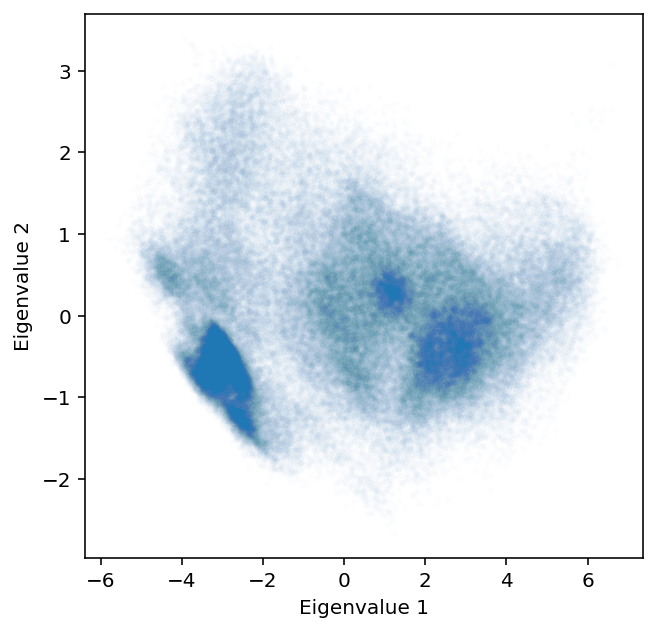

In [3]:
# Project onto 2 axes with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # 2 components
pca.fit(X) # Do the fitting


X_reduced = pca.transform(X)

plt.figure(figsize=(5,5))
plt.scatter(X_reduced[:,0], X_reduced[:,1], 
            marker=".", color='C0', 
            alpha=0.01, edgecolors='None')
plt.xlabel('Eigenvalue 1')
plt.ylabel('Eigenvalue 2')
axes=plt.gca()


plt.show()

The above image shows the data projected into **two linear combinations that encompass the directions of greatest variance**. In the following, we'll do $K$-means clustering in these dimensions.

In [4]:
# Compute the KMeans clustering
n_clusters = 6
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(X_reduced))

KMeans(n_clusters=6)

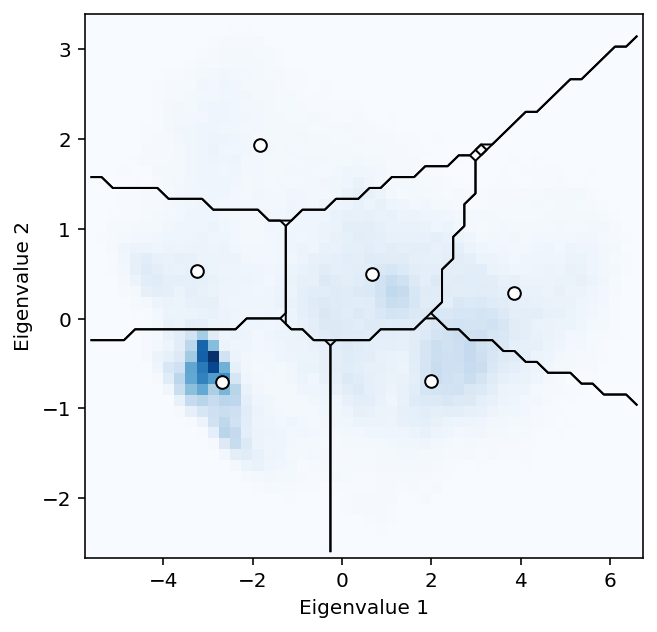

In [5]:
# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X_reduced[:,0], X_reduced[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

    H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

plt.savefig("sample_after_kmeans.pdf")

The above figure displays the underlying density of samples, the cluster centers, and the cluster boundaries.

<font color='red'>Change the number of clusters and compare the outcome.</font>

In [7]:
# Compute the KMeans clustering
n_clusters = 10
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(X_reduced))

KMeans(n_clusters=10)

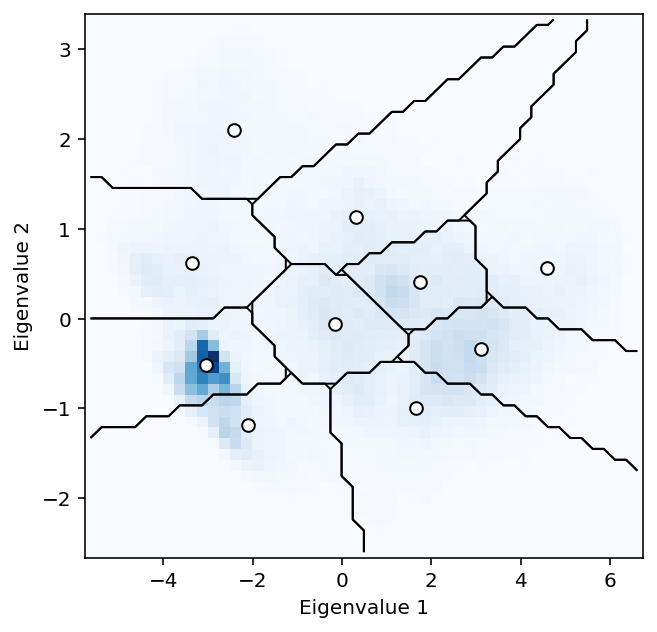

In [8]:
# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X_reduced[:,0], X_reduced[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

    H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

plt.savefig("sample_after_kmeans.pdf")

When adding number of the cluster, the number of sectors increase, but the properties of the data did not change. They are just classified more detailed. 

## 2. Unsupervised Classification: Anomaly Detection <a class="anchor" id="first-bullet"></a>

One efficient way of performing outlier detection in high-dimensional datasets is to use random forests. The *isolation forest* implementation ensemble.IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

The implementation of ensemble.IsolationForest is based on an ensemble of tree.ExtraTreeRegressor. Following Isolation Forest original paper, the maximum depth of each tree is set to $ \lceil log_2(n) \rceil$
where $n$ is the number of samples used to build the tree (see (Liu et al., 2008) for more details).

*References:* Liu, Fei Tony, Ting, Kai Ming and Zhou, Zhi-Hua. “Isolation forest.” Data Mining, 2008. ICDM’08. Eighth IEEE International Conference on.

The usage of this algorithm as implemented in `scikit-learn` is illustrated below.

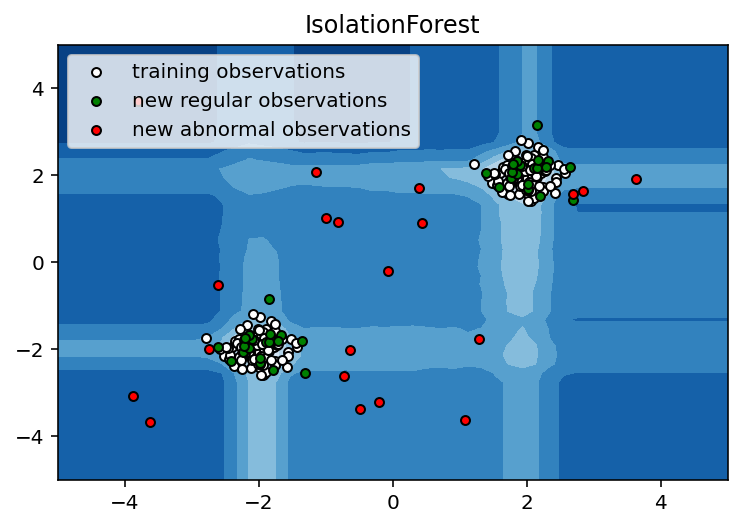

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c="white", s=20, edgecolor="k")
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c="green", s=20, edgecolor="k")
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c="red", s=20, edgecolor="k")
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend(
    [b1, b2, c],
    ["training observations", "new regular observations", "new abnormal observations"],
    loc="upper left",
)
plt.show()

## Summary <a class="anchor" id="fourth-bullet"></a>

At this point, all of you should have:
* seen how clustering algorithms can be accessed within `scikit-learn`
* how unsupervised classification can help with detecting unusual data in our data sets.